## Toy Models of Superposition -- paper replication
### Section 2

This notebook presents the results of the replication of Section 2 of the paper 'Toy Models of Superposition', Elhage et al.

In [1]:

import torch as t
import os

from typing import Union, Optional
from einops import rearrange, reduce, repeat
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

import matplotlib as mlp
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.pyplot import matshow

from training import generate_synthetic_data, train, ProjectAndRecover, load_saved_models, SPARSITIES
from visualization import plot_weights_and_bias, visualize_superposition

SMALL_MODELS_PATHNAME = "./model-weights/section2-small/"
BIG_MODELS_PATHNAME = "./model-weights/section2-big/"
SPARSITIES = [0., .7, .9, .97, .99, .997, .999]
device = 'cpu'

We want to understand whether models store features in superposition if there are more features than neurons (in the smallest layer of the model). We consider a model of the following architecture:

The first layer is a linear transformation that projects a vector of dimension `input_dim` to a vector of dimension `hidden_dim`, i.e. it is multiplication with a matrix of shape (input_dim, hidden_dim). The second layer is given by the transpose of this matrix and recovers the input dimension. As activation function we take a ReLU.

We generate data where each feature (here given as the standard basis vectors) is zero with probability `sparsity` and uniformly distributed in $[0,1]$ otherwise.

Below we train one model on this data with respect to the loss function mean squared error, weighted by the vector `importance`.

In [14]:
input_dim = 20                   # 20 for small models / 80 for big models
hidden_dim = 5                   # 5 for small models / 20 for big models
sparsity = 0.9                   # or any float in [0,1)
importance_factor = .7           # .7 for small models / .9 for big models
importance = t.tensor([importance_factor ** i for i  in range(input_dim)])
    
size_trainingdata = 100000
data = generate_synthetic_data(input_dim, size_trainingdata, sparsity)

batch_size = 128
epochs = 15

trainloader = DataLoader(tuple((data)), batch_size= batch_size)
model = ProjectAndRecover(input_dim, hidden_dim, importance).to(device).train()
model = train(model, trainloader, epochs=epochs)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0, train loss is 0.011996200308203697
Epoch 1, train loss is 0.0035850510466843843
Epoch 2, train loss is 0.0017819389468058944
Epoch 3, train loss is 0.0011786535615101457
Epoch 4, train loss is 0.0009783366695046425
Epoch 5, train loss is 0.0009133180719800293
Epoch 6, train loss is 0.0008626392227597535
Epoch 7, train loss is 0.000807334843557328
Epoch 8, train loss is 0.0004883421934209764
Epoch 9, train loss is 0.00043752501369453967
Epoch 10, train loss is 0.00043904822086915374
Epoch 11, train loss is 0.0004434557049535215
Epoch 12, train loss is 0.0005404656985774636
Epoch 13, train loss is 0.0005425667623057961
Epoch 14, train loss is 0.0005425229319371283


We visualize the resulting weight matrix $W^T W$, given by concatenating the first two layers, and the bias vector b. 

For `sparsity` = 0.0 we see that only the first `hidden_dim` features are represented, by the first column vectors which are the first standard basis vectors in this case. For larger sparsities we see that more and more features are represented. For `sparsity` = .7, the visualization indicates that a pair of two features is represented by one neuron. For different training runs the pairs differ.

You can train models of different sizes and for different sparsities. For the latter think on a log scale; changes in values close to 1 make a bigger difference.

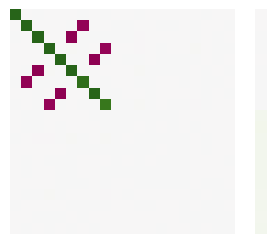

In [17]:
W = model.weights.data
b = model.bias.data
plot_weights_and_bias(W, b)

We compute the superposition metric as described in the paper and visualize it below. Each bar corresponds to one feature, the i-th column $W_i$ of the weight matrix $W$. [...]

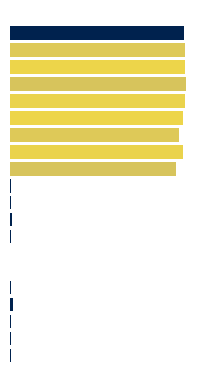

In [18]:
visualize_superposition(model.weights)

In [42]:
# load saved models
small_models = {}
load_saved_models(small_models)

big_models = {}
load_saved_models(big_models, big = True)

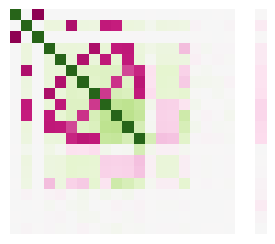

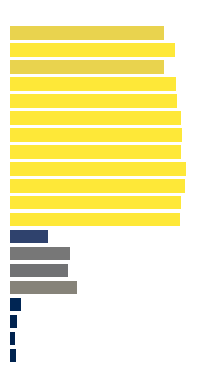

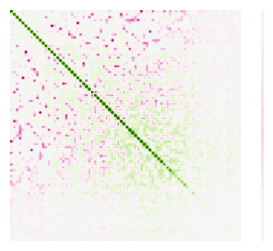

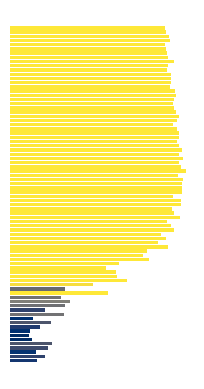

In [43]:

# visualize saved models
i = 5 # choose i <= 6
small_model = small_models[SPARSITIES[i]] 
plot_weights_and_bias(small_model.weights.data, small_model.bias.data)
visualize_superposition(small_model.weights)
big_model = big_models[SPARSITIES[i]] 
plot_weights_and_bias(big_model.weights.data, big_model.bias.data)
visualize_superposition(big_model.weights)




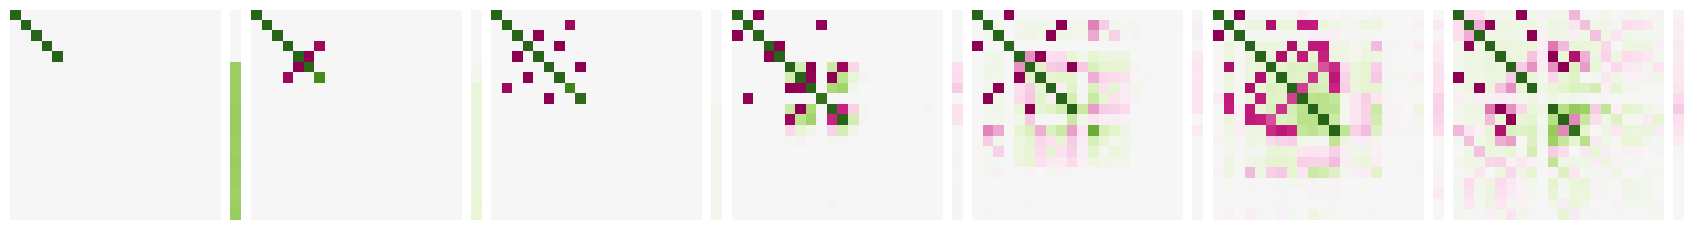

In [10]:

#  visualize all small models
fig = plt.figure(figsize=(21.6, 3))
grid = ImageGrid(fig, 111,  
                nrows_ncols=(1, 14),
                axes_pad=0.1
                )
plotpairs =[]
for sparsity in SPARSITIES:
    W,b = small_models[sparsity].weights.data, small_models[sparsity].bias.data
    plotpairs += [W.T @ W, b.reshape((len(b), 1))]
for ax, im in zip(grid, plotpairs):
    ax.set_axis_off()
    ax.imshow(im, origin="upper", vmin= -1, vmax= 1, cmap=mlp.colormaps['PiYG'])
    ax.set_label(f'Weight matrix and bias for sparsity {sparsity}')
plt.show()

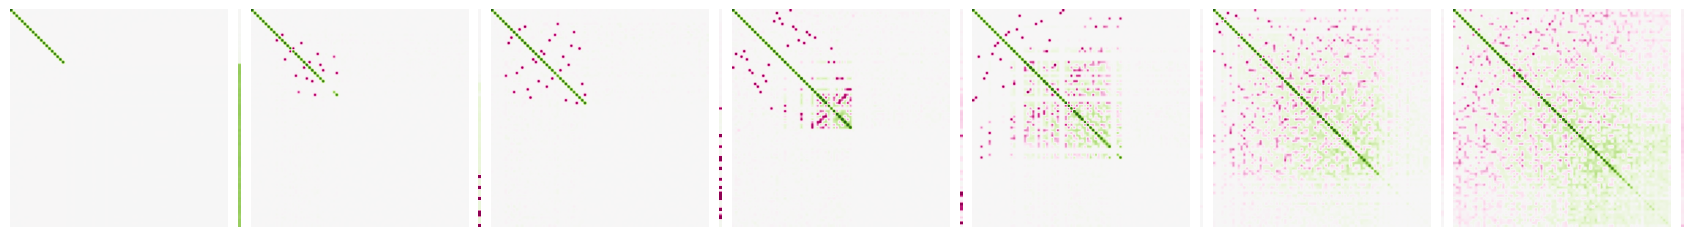

In [12]:
#visualize all large models
fig = plt.figure(figsize=(21.6, 3))
grid = ImageGrid(fig, 111,  
                nrows_ncols=(1, 14),
                axes_pad=0.1
                )
plotpairs =[]
for sparsity in SPARSITIES:
    W,b = big_models[sparsity].weights.data, big_models[sparsity].bias.data
    plotpairs += [W.T @ W, b.reshape((len(b), 1))]
for ax, im in zip(grid, plotpairs):
    ax.set_axis_off()
    ax.imshow(im, origin="upper", vmin= -1, vmax= 1, cmap=mlp.colormaps['PiYG'])
    ax.set_label(f'Weight matrix and bias for sparsity {sparsity}')
plt.show()
